In [65]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import torch
import model 
# import losses
#from botorch.models import SingleTaskGP
#from botorch.fit import fit_gpytorch_mll
#from botorch.utils import standardize+
# from gpytorch.mlls import ExactMarginalLogLikelihood
import gt_sampling
import torch.optim as optim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from utils.soft_dtw import SoftDTW

import torch
# import torch.nn as nn
# import torch.nn.functional as F
from utils.utils import plot_simulated_meshgrid, plot_collage
import torch.distributions as dist
# from bayes_opt import BayesianOptimization
# from bayes_opt import BayesianOptimization
# from bayes_opt import UtilityFunction
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import gridspec

sys.path.append("../misc")
import bbob_deferential as bobby



In [66]:
# create ground truth functions
n_dim = 2
samples = 1000
seed = 42

def create_problem(f_number, n_dim, seed):
    if f_number == 1:
        problem = bbobtorch.create_f01(n_dim, seed=seed)
    elif f_number == 3:
        problem = bobby.create_f03(n_dim, seed=seed)
    elif f_number == 24:
        problem = bobby.create_f24(n_dim, seed=seed)

    return problem

problem_f01 = create_problem(1, n_dim, seed)
problem_f03 = create_problem(3, n_dim, seed)
problem_f24 = create_problem(24, n_dim, seed)
problem_f00 = lambda x: (1/4*x**2-1/2*x).sum(dim=1, keepdim=True)

In [67]:
# sampling from groundtruth functions
sample_f01 = gt_sampling.get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random', )
sample_f03 = gt_sampling.get_sample(problem_f03, n_samples=samples, n_dim=2, seed=42, method='random',)
sample_f24 = gt_sampling.get_sample(problem_f24, n_samples=samples, n_dim=2, seed=42, method='random',)
sample_f00 = gt_sampling.get_sample(problem_f00, n_samples=samples, n_dim=2, seed=42, method='random',)

## Simulate the function with NN

In [164]:
y = bobby.create_f01(1)(x)
for y_, x_ in zip(y, x):
    # print(x_.is_leaf)
    # print(y_.is_leaf)
    abc = torch.autograd.grad(y_, x_, create_graph=True)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [162]:
y

tensor([ 71.6589,  47.2104,  85.5598,  79.8331, 107.8136,  98.5885,  78.0153,
         72.9910,  57.4224,  30.9248,  58.8564,  54.9514, 177.5404,  26.2184,
         41.2772,  29.3158,  36.9651,  46.2997, 151.8794, 113.3289,  82.9343,
         67.0878,  34.5418,  77.2389,  48.9646,  33.8566, 105.4894, 119.7351,
        106.6253,  92.1337,  75.3219,  66.1315, 128.8695,  33.8280,  37.3104,
         51.5061,  78.8940,  38.1410, 164.9174, 131.7355, 141.4940,  31.3629,
         70.0944, 109.7928, 139.3916, 132.1680,  84.4404,  50.6551, 131.3731,
         80.5487, 133.3666,  34.1435,  63.9744, 136.8412,  26.8992,  68.0855,
        102.3615,  81.0856,  59.3542, 108.3556,  50.0071,  78.8067,  74.8676,
        102.0472,  45.0536, 183.8176,  40.9423,  33.6935, 160.3159,  45.0554,
        108.8252, 114.5570, 113.6517, 100.8411, 139.1363, 118.6658, 114.5245,
         98.5147,  78.2274,  69.9321, 147.0259, 106.2443,  45.6146, 115.0574,
         47.1321,  51.8675, 102.2574,  38.7990,  44.0093,  68.47

In [159]:
abc

(tensor([[-0.0000,  0.0000],
         [-0.0000, -0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000, -0.0000],
         [-0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000, -0.0000],
         [ 0.0000, -0.0000],
         [-0.0000,  0.0000],
         [-0.0000, -0.0000],
         [-0.0000,  0.0000],
         [-0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.0000, -0.0000],
         [-0.0000, -0.0000],
         [-0.0000, -0.0000],
         [-0.0000, -0.0000],
         [-0.0000, -0.0000],
         [ 0.0000,  0.0000],
         [-0.0000,  0.0000],
         [ 0.0000, -0.0000],
         [-0.0000,  0.0000],
         [-0.0000, -0.0000],
         [ 0.0000, -0.0000],
         [-0.0000, -0.0000],
         [-0.0000, -0.0000],
         [-0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000, -0.0000],
         [-0.0000,  0.0000],
         [-0.0000,  0.0000],
         [-0.0000,  0.0000],
         [ 0.0000, -0.0000],
         [-0.0000, -0.0000],
         [-0.0

In [145]:
y

tensor([-959.4121, -970.6079, -994.6346, -989.4135, -931.3750, -993.1011,
        -998.2906, -997.3361, -978.2286, -942.3046, -974.8923, -969.9766,
        -975.6987, -928.9386, -975.9352, -952.6560, -972.6417, -984.0485,
        -988.6785, -921.8693, -986.0479, -985.6669, -942.6401, -998.2073,
        -983.7610, -965.3477, -944.6082, -996.2368, -993.0283, -960.2110,
        -976.9065, -951.7092, -993.4033, -965.4687, -971.3284, -964.0421,
        -981.7548, -971.1316, -984.9500, -994.7412, -982.9768, -941.9016,
        -946.9612, -927.1098, -992.3529, -996.2135, -991.3657, -960.4279,
        -977.4258, -984.9146, -993.2468, -948.6530, -957.3982, -995.4266,
        -931.4144, -990.6022, -945.9356, -990.7881, -992.6317, -961.2961,
        -964.8138, -996.9174, -952.7400, -941.1893, -958.2653, -974.1814,
        -957.6922, -960.9859, -984.3499, -942.9477, -978.9608, -993.7518,
        -982.6071, -982.7850, -980.1256, -987.8495, -987.9525, -999.9838,
        -996.1428, -978.4089, -976.432

In [137]:
def higher_order_derivatives(f, wrt, n):
    derivatives = []
    for i in range(f.shape[0]):#f_, wrt_ in zip(f, wrt):
        # print("I")
        # print("V")
        # print(f_)
        # derivatives.append(f.mean())
        f_ = f.select(0, i)
        wrt_ = wrt.select(0, i)
        print(f_.is_leaf)
        for _ in range(n):
            print(f_)
            print(wrt_)
            grads = torch.autograd.grad(f_, wrt_)#, create_graph=True)[0]
            print(grads)
            derivatives.append(grads)
            f_ = grads
    return torch.stack(derivatives)


class KnollHaZeHei(torch.nn.Module):
    def __init__(self, diff_degree, criterion):
        super().__init__()
        self.diff_degree = diff_degree
        self.criterion = criterion

    def forward(self, pred, true, x):
        true = higher_order_derivatives(true, x, self.diff_degree)
        pred = higher_order_derivatives(pred, x, self.diff_degree)
        loss = self.criterion(pred.flatten(), true.flatten())
        return loss

In [138]:
input_dim = 2
hidden_dim = 16
hidden_layers = 4
output_dim = 1
learning_rate = 0.0001
num_epochs = 1000
bs = 256

y_weight = 1.0
first_derivative_weight = 0.5
second_derivative_weight = 0.2

m = model.NN(input_dim, hidden_dim, hidden_layers)
optimizer = optim.SGD(m.parameters(), lr=learning_rate)
criterion =KnollHaZeHei(1, torch.nn.MSELoss())#  CustomLoss(y_weight, first_derivative_weight, second_derivative_weight)#

# Training loop
for epoch in range(num_epochs):
    x = X_input.clone().detach().requires_grad_(True)
    x = x[torch.randperm(samples)][:bs]

    optimizer.zero_grad()
    trues = bobby.create_f01(2)(x)
    preds = m(x)
    
    Karloss = criterion(preds, trues, x)

    # Backward and optimize
    Karloss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Karloss.item():.4f}')

False
tensor(76.8738, grad_fn=<SelectBackward0>)
tensor([-3.2648,  1.9495], grad_fn=<SelectBackward0>)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:

# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = m(mesh_samples_tensor).reshape(X.shape)

<Axes: title={'center': 'Simulated Function from NN'}, xlabel='X1', ylabel='X2'>

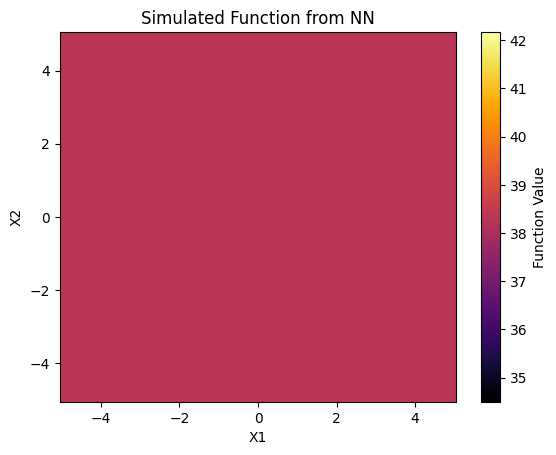

In [71]:
plot_simulated_meshgrid(X, Y, mesh_results, model='NN')


<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

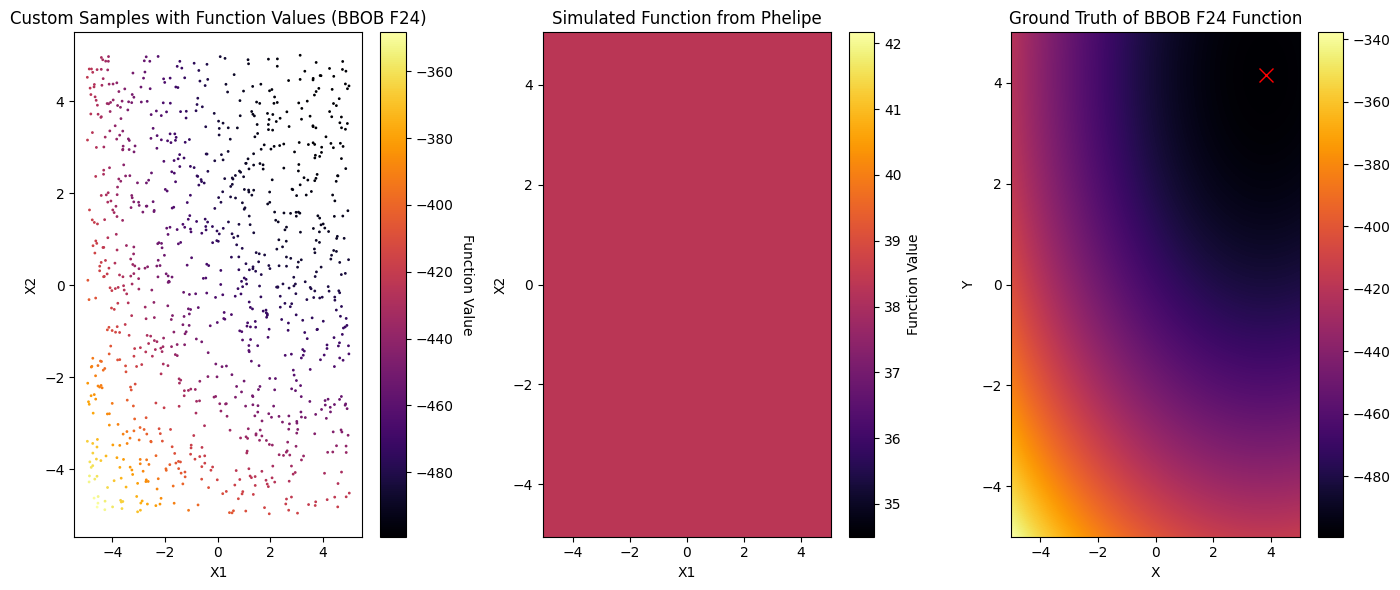

In [72]:
plot_collage(sample_f01[0].detach().numpy(), sample_f01[1].detach().numpy(), problem_f01, "BBOB F24", "Phelipe", X, Y, mesh_results)
#samples, results, problem, problem_name, model_name, X, Y, mesh_results

In [22]:
# pickle nn model

sys.path.append("../")

torch.save(m.state_dict(), "../models/f01_mse_nn_model.pt")

## Simulation with Monte Carlo Simulation


XXX until now just taken from the internet

In [ ]:
# Use Gaussian Process Regression to approximate the function
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process Regression model to the Monte Carlo samples
gpr_model.fit(monte_carlo_samples, monte_carlo_results)

# Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the GPR model on the mesh grid
mesh_results, _ = gpr_model.predict(mesh_samples, return_std=True)
mesh_results = mesh_results.reshape(X.shape)

NameError: name 'monte_carlo_samples' is not defined

In [ ]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)

TypeError: plot_collage() missing 1 required positional argument: 'mesh_results'

## Simulation with Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
# simulate the function with the aboth samples and results
X_svc = X_input
y_svc = y_input.float()
model_name = "SVR Model"

In [ ]:
# define svr model
# XXX parameters are not optimized
svr_model = SVR(kernel='rbf', C=4.0, epsilon=0.6)

# Fit the SVR model to the Monte Carlo samples
svr_model.fit(X_svc, y_svc)


SVR(C=4.0, epsilon=0.6)

In [ ]:
#Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the SVR model on the mesh grid
mesh_results = svr_model.predict(mesh_samples)
mesh_results = mesh_results.reshape(X.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

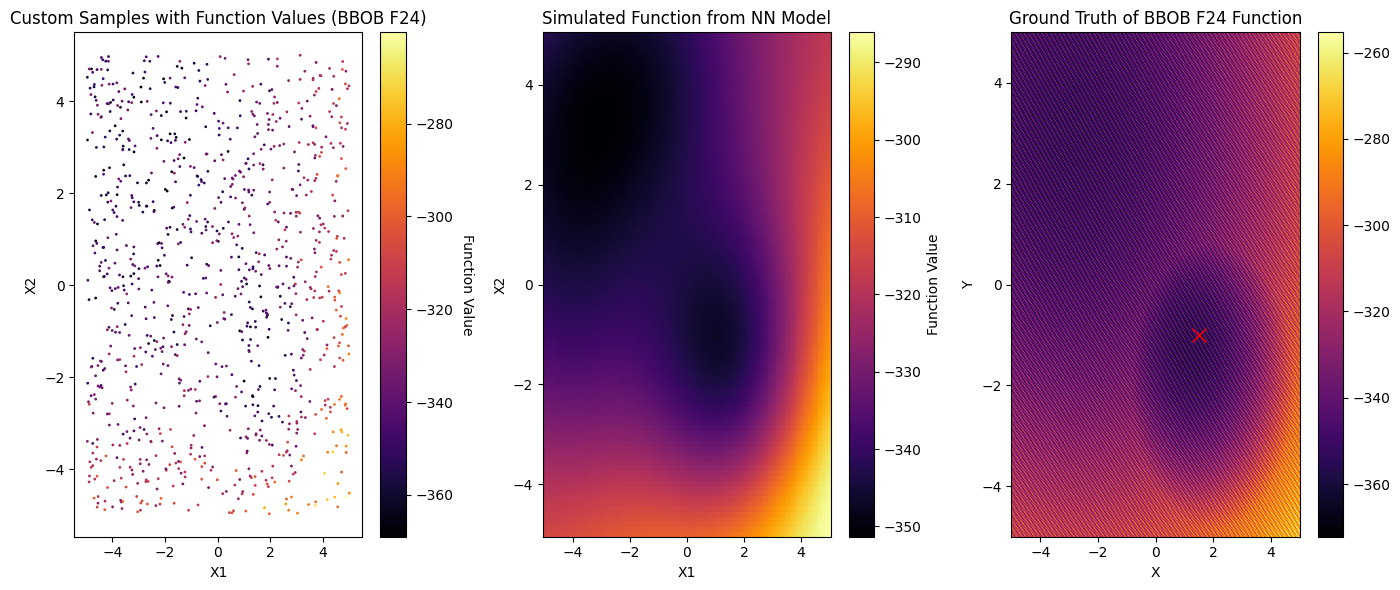

In [ ]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)

C:\Users\Pascal\AppData\Local\Temp\ipykernel_29988\981844319.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  edge_index = torch.tensor(kneighbors_graph(points, k, mode='connectivity').toarray().nonzero(), dtype=torch.long)


Epoch [100/1000], Loss: 44848196.0
Epoch [200/1000], Loss: 31076618.0
Epoch [300/1000], Loss: 16631369.0
Epoch [400/1000], Loss: 9497599.0
Epoch [500/1000], Loss: 7926166.0
Epoch [600/1000], Loss: 7696048.5
Epoch [700/1000], Loss: 7576297.0
Epoch [800/1000], Loss: 7452859.0
Epoch [900/1000], Loss: 7321326.5
Epoch [1000/1000], Loss: 7181539.0


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.

In [ ]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = model(mesh_samples_tensor).reshape(X.shape)

AttributeError: 'Tensor' object has no attribute 'x'

In [ ]:
plot_simulated_meshgrid(X, Y, mesh_results, model='NN')

In [ ]:
!pip install torch_geometric

                                              0.0/661.6 kB ? eta -:--:--
     -----                                   92.2/661.6 kB 5.1 MB/s eta 0:00:01
     ------------------------               430.1/661.6 kB 5.4 MB/s eta 0:00:01
     -------------------------------------- 661.6/661.6 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910499 sha256=b4fbdef4bacbdfed17dfc8c56dca16fcba07d024d0302abeb7029fdf52c9e673
  Stored in directory: c:\users\pascal\appdata\local\pip\cache\wheels\ac\dc\30\e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
  Using cached torch_ge